<a href="https://colab.research.google.com/github/Anjasfedo/Code-as-a-Cryptography/blob/main/ecc_lsb_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Elliptic Curve Criptography

with library that use schema of ECDH + AES
1. Elliptic Curve Diffle Hellman for key exchange
2. AES to encrypt & decrypt the massage/plaintext

In [1]:
!pip install eciespy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.3 MB/s eta 0:00:00


In [2]:
CONTENT = "3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup"

In [3]:
from ecies.utils import generate_eth_key
from ecies import encrypt, decrypt

private_key = generate_eth_key()
public_key = private_key.public_key

public_key_hex = public_key.to_hex()
private_key_hex = private_key.to_hex()

print("Public Key:", public_key_hex)
print("Private Key:", private_key_hex)

ciphertext = encrypt(public_key_hex, CONTENT.encode())

print("Ciphertext:", ciphertext.hex())

decrypted_message = decrypt(private_key_hex, ciphertext)
print("Decrypted Message:", decrypted_message.decode())

Public Key: 0x4242f5054cc6b34622d4951e0b323738ae56ae0abb64d4ae4133324b85dca48ff7e165093dfc4228c29c21d4d664ba2e8ff1ebda2b3105992c7da2206a82bdde
Private Key: 0x8817f03cf8a0d86c3eed761aebd53a66c32684f0522b7bed1558aa048dcfaeee
Ciphertext: 04bcecd5fd531b2093f95ee3c86baca48402c1ff3f84c7c56d1ff3e63c725254098c4812cc876c659287e512778d7670a7bdc124732a22ee92ac388c36792effc55dc7809860903dd152883671bbaaa066d263c280596b495b17604e56c950164fc7beb38c59cc8d6979605081d3db57b43fcb3701a649696b2de3411231442504775d6b2d21874343298e6433a4e4ae42eeb286c6a777ca69dc05dd7bc2ceef1bd55d6b95247ebe3d05882421f5bf03a8a3cd39d9a7433e0803853b5091b89edc266436fe66470ed16ebf9c17a390abb7d701888583c633cde305e1a1f6066d593efe9c4ca23ea434d72f6a6da2940027a65045be1f91cd3b7d3da3308b352edb2b6b84a0120656b216174b3f3ecf531d9a
Decrypted Message: 3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup


# Koblitz Method & Elliptic Curve El Gamal

## Koblitz Method

to encode & decode integer to coordinate point on cartesius

In [4]:
# Parameters
p = 751  # prime modulus
k = 20    # chosen small integer
a = -1    # coefficient of x in the elliptic curve
b = 188    # constant in the elliptic curve

### Char to Num & Num to Char

In [5]:
# Manually create dictionaries for char-to-num and num-to-char mappings
char_to_num_dict = {
    '0': 10, '1': 11,
    'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19,
    'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27,
    'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35
}

# Reverse dictionary for num-to-char mapping
num_to_char_dict = {v: k for k, v in char_to_num_dict.items()}

# Function to map char to num
def char_to_num(char):
    if char in char_to_num_dict:
        return char_to_num_dict[char]
    else:
        raise ValueError(f"Character '{char}' is not valid. Please use '0-1' or 'a-x'.")

# Function to map num to char
def num_to_char(num):
    if num in num_to_char_dict:
        return num_to_char_dict[num]
    else:
        raise ValueError(f"Number '{num}' is not valid. Please use numbers in the range 10-35.")

def message_to_koblitz(message):
    # Convert the message to a list of characters
    chars = list(message)

    koblitz = []
    for char in chars:
        num = char_to_num(char)
        koblitz.append(num)

    return koblitz

def koblitz_to_message(koblitz):
    message = []
    for num in koblitz:
        char = num_to_char(num)
        message.append(char)

    return ''.join(message)

# Test mapping from char to num
chars = '01ax'

koblitz_message = message_to_koblitz(chars)
print("Koblitz Message:", koblitz_message)

message = koblitz_to_message(koblitz_message)
print("Message:", message)

Koblitz Message: [10, 11, 12, 35]
Message: 01ax


### Koblitz Encoding

In [6]:
import sympy as sp

# Elliptic curve equation: y^2 = x^3 + ax + b mod p
def koblitz_encode(m, max_attempts=1000):
    num = 1  # Start with x = m * k + 1
    attempts = 0

    while attempts < max_attempts:
        x = m * k + num
        rhs = (x**3 + a * x + b) % p  # right-hand side of the elliptic curve equation

        # Check if rhs is a quadratic residue modulo p
        if sp.is_quad_residue(rhs, p):
            y = sp.sqrt_mod(rhs, p)
            return (x, y)  # Return the point (x, y) as a tuple

        num += 1  # Increment to check next x value
        attempts += 1

    # If no valid point is found after max_attempts
    raise ValueError(f"No valid point found after {max_attempts} attempts for message {m}.")

def koblitz_encode_message(message):
  encoded_points = []
  for char in message:
    encoded_point = koblitz_encode(char)
    encoded_points.append(encoded_point)
    print(f"Encoded point for character '{char}': {encoded_point}")

  return encoded_points

encoded_points = koblitz_encode_message(koblitz_message)
encoded_points

Encoded point for character '10': (201, 5)
Encoded point for character '11': (224, 248)
Encoded point for character '12': (241, 230)
Encoded point for character '35': (701, 203)


[(201, 5), (224, 248), (241, 230), (701, 203)]

### Koblitz Decoding

In [7]:
# Decoding: m = (x - 1) / k
def koblitz_decode(x):
    return (x - 1) // k

def koblitz_decode_message(points):
    decoded_message = []
    for point in points:
        decoded_num = koblitz_decode(point[0])  # Decode the x-coordinate
        decoded_message.append(decoded_num)
        print(f"Decoded character for point {point}: {decoded_num}")
    return decoded_message

# Output the result
decoded_points = koblitz_decode_message(encoded_points)
decoded_points

Decoded character for point (201, 5): 10
Decoded character for point (224, 248): 11
Decoded character for point (241, 230): 12
Decoded character for point (701, 203): 35


[10, 11, 12, 35]

In [8]:
message = koblitz_to_message(decoded_points)
message

'01ax'

## Elliptic Curve El Gamal

Elliptic Curve with El Gamal

In [9]:
# Parameters
p = 11  # prime modulus
# k = 20    # chosen small integer
a = 1    # coefficient of x in the elliptic curve
b = 6    # constant in the elliptic curve
# B = (2, 4)

In [10]:
# Parameters
p = 751  # prime modulus
a = -1    # coefficient of x in the elliptic curve
b = 188    # constant in the elliptic curve

In [136]:
import random
import sympy as sp
import json
import base64

class EllipticCurveElGamal:
  def __init__(self, a, b, p, k, B=None):
    self.p = p # primer number
    self.a = a # alpha
    self.b = b # beta

    self.k = k
    self.PointB = B

    self.pointP = None
    self.pointQ = None


    self.char_to_num_dict = {
    '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
    'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17,
    'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25,
    'q': 26, 'r': 27, 's': 28, 't': 29, 'u': 30, 'v': 31, 'w': 32, 'x': 33,
    'y': 34, 'z': 35, '.': 36, '#': 37, '*': 38, '/': 39, '-': 40
    }

    self.num_to_char_dict = {v: k for k, v in self.char_to_num_dict.items()}

    self.k_koblitz = max(self.char_to_num_dict.values()) + 1  # max 24 for 35 char

  def example_function(self):
      print(f"Using persistent k value: {self.k}")

  def elliptic_curve_equation(self, x):
    return (x**3 + self.a*x + self.b) % self.p

  def is_on_curve(self, x, y):
    return self.elliptic_curve_equation(x)  == (y**2) % p

  # def generate_random_number(self):
  #   self.k = random.randint(1, self.p - 1)
  #   return self.k

  def generate_random_point(self):
    while True:
      x = random.randint(1, self.p - 1)
      y = random.randint(1, self.p - 1)
      if self.is_on_curve(x, y):
        return (x, y)

  def mod_inverse(self, a, p):
      if a == 0:
          raise ValueError("Inverse does not exist for 0.")
      return pow(a, p - 2, p)

  def calculate_slope_mod(self, P, Q):
    x1, y1 = P
    x2, y2 = Q
    if x1 == x2 and y1 == y2:
        # Use the formula for point doubling when P == Q
        numerator = (3 * x1**2 + self.a) % self.p
        denominator = (2 * y1) % self.p
    else:
        # Use the formula for regular slope when P != Q
        numerator = (y2 - y1) % self.p
        denominator = (x2 - x1) % self.p

    if denominator == 0:
        raise ValueError("Slope is undefined (denominator is zero).")

    # Compute the slope as (numerator / denominator) % p, which is
    # numerator * mod_inverse(denominator, p) % p
    slope = (numerator * self.mod_inverse(denominator, self.p)) % self.p
    return slope

  def calculate_add_xr_mod(self, P, Q, m):
    x1, y1 = P
    x2, y2 = Q
    xr = (m**2 - x1 - x2) % self.p
    return xr

  def calculate_add_yr_mod(self, P, Q, m, xr):
    x1, y1 = P
    x2, y2 = Q
    yr = (m * (x1 - xr) - y1) % self.p
    return yr

  def calculate_point_addition(self, P, Q):
    m = self.calculate_slope_mod(P, Q)

    xr = self.calculate_add_xr_mod(P, Q, m)

    yr = self.calculate_add_yr_mod(P, Q, m, xr)

    R = (xr, yr)

    return R

  def calculate_dob_xr_mod(self, P, Q, m):
    x1, y1 = P
    x2, y2 = Q
    xr = (m**2 - (2 * x1)) % self.p
    return xr

  def calculate_dob_yr_mod(self, P, Q, m, xr):
    x1, y1 = P
    yr = (m * (x1 - xr) - y1) % self.p
    return yr

  def calculate_point_doubling(self, P):

    m = self.calculate_slope_mod(P, P)

    xr = self.calculate_dob_xr_mod(P, P, m)

    yr = self.calculate_dob_yr_mod(P, P, m, xr)

    R = (xr, yr)

    return R

  def calculate_point_multiplication(self, P, k):
    if k == 0:
      return None
    elif k == 1:
      return P

    # Initialize R to be the point at infinity, often represented as None in this context
    R = None
    Q = P  # Start with Q as P

    # Double-and-add method
    while k > 0:
        if k % 2 == 1:  # If k is odd, add Q to the result
            if R is None:
                R = Q  # R is the point at infinity initially
            else:
                R = self.calculate_point_addition(R, Q)
        Q = self.calculate_point_addition(Q, Q)  # Double the point Q
        k //= 2  # Move to the next bit

    return R

  def calculate_point_subtract(self, P, Q):
    # Find the inverse of point Q (x_Q, y_Q) -> (x_Q, -y_Q mod p)
    Q_inv = (Q[0], (-Q[1]) % self.p)

    # Subtract P - Q by adding P and Q_inv
    R = self.calculate_point_addition(P, Q_inv)

    return R

  def generate_public_key(self, B, private_key):
    public_key = self.calculate_point_multiplication(B, private_key)
    return public_key

  def enryption(self, M, public_key):
    # k = random.randint(1, self.p - 1) # 1 < k < p - 1

    C1 = self.calculate_point_multiplication(self.PointB, self.k)
    C2 = self.calculate_point_addition(M, self.calculate_point_multiplication(public_key, self.k))

    return (C1, C2)

  def decryption(self, C, private_key):
    C1, C2 = C

    _p = self.calculate_point_multiplication(C1, private_key)

    plain = self.calculate_point_subtract(C2, _p)

    return plain

  # Function to map char to num
  def char_to_num(self, char):
      # Ensure the input is a string; if not, convert it
      char = str(char)

      # Check if the string exists in the dictionary
      if char in self.char_to_num_dict:
          return self.char_to_num_dict[char]
      else:
          # Handle the expanded character set (0-40)
          raise ValueError(f"Character '{char}' is not valid. Please use '0-9', 'a-z', or other valid characters.")


  # Function to map num to char
  def num_to_char(self, num):
      # Ensure that the input is an integer; if it's a string digit, convert to integer
      if isinstance(num, str) and num.isdigit():
          num = int(num)

      # Now we expect num to be an integer
      if isinstance(num, int):
          if num in self.num_to_char_dict:  # Handle numbers 0-40 by converting them using the dictionary
              return self.num_to_char_dict[num]
          else:
              raise ValueError(f"Number '{num}' is out of the valid range (0-40).")
      else:
          raise ValueError(f"Input '{num}' is not valid. Please provide a valid number.")


  def message_to_koblitz(self, message):
      # Convert the message to a list of characters
      chars = list(message)

      koblitz = []
      for char in chars:
          num = self.char_to_num(char)
          koblitz.append(num)

      return koblitz

  def koblitz_to_message(self, koblitz):
      message = []
      for num in koblitz:
          char = self.num_to_char(num)
          message.append(char)

      return ''.join(message)

  def koblitz_encode(self, m, max_attempts=1000):
    num = 1  # Start with x = m * k + 1
    attempts = 0

    while attempts < max_attempts:
        x = m * self.k_koblitz + num
        rhs = (x**3 + self.a * x + self.b) % self.p  # right-hand side of the elliptic curve equation

        # Check if rhs is a quadratic residue modulo p
        if sp.is_quad_residue(rhs, self.p):
            y = sp.sqrt_mod(rhs, self.p)
            return (x, y)  # Return the point (x, y) as a tuple

        num += 1  # Increment to check next x value
        attempts += 1

    # If no valid point is found after max_attempts
    raise ValueError(f"No valid point found after {max_attempts} attempts for message {m}.")

  def koblitz_encode_message(self, message):
    encoded_points = []
    for char in message:
      encoded_point = self.koblitz_encode(char)
      encoded_points.append(encoded_point)
      # print(f"Encoded point for character '{char}': {encoded_point}")

    return encoded_points

  def koblitz_decode(self, x):
    return (x - 1) // self.k_koblitz

  def koblitz_decode_message(self, points):
      decoded_message = []
      for point in points:
          decoded_num = self.koblitz_decode(point[0])  # Decode the x-coordinate
          decoded_message.append(decoded_num)
          # print(f"Decoded character for point {point}: {decoded_num}")
      return decoded_message

  def encrypt_message(self, message, public_key):
      # Encode the message into Koblitz points
      koblitz_message = self.message_to_koblitz(message)
      encoded_message = self.koblitz_encode_message(koblitz_message)
      encrypted_points = []

      # Encrypt each Koblitz point
      for point in encoded_message:
          encrypted_point = self.enryption(point, public_key)
          encrypted_points.append(encrypted_point)

      # Convert encrypted_points (a list of tuples) to a JSON string
      encrypted_message_string = json.dumps(encrypted_points)

      # Optionally, encode the string to base64 for a cleaner ciphertext
      encrypted_message_base64 = base64.b64encode(encrypted_message_string.encode()).decode()

      return encrypted_message_base64, encrypted_points  # Return as readable string

  def decrypt_message(self, encrypted_message_base64, private_key):
      # Decode the base64 string back to the JSON string
      encrypted_message_string = base64.b64decode(encrypted_message_base64).decode()

      # Convert the JSON string back to a list of encrypted points (tuples)
      encrypted_points = json.loads(encrypted_message_string)

      decrypted_message = []

      # Decrypt each point
      for point in encrypted_points:
          decrypted_point = self.decryption(point, private_key)
          decrypted_message.append(decrypted_point)

      # Decode the Koblitz points into the original numeric values
      decoded_koblitz_points = self.koblitz_decode_message(decrypted_message)

      # Convert numeric Koblitz points to characters using num_to_char
      plain_text_message = ''.join([self.num_to_char(num) for num in decoded_koblitz_points])

      return plain_text_message

In [137]:
random_num = random.randint(1, p - 1)
print(f'random number: {random_num}')

elliptic1 = EllipticCurveElGamal(a, b, p, random_num)

# k = elliptic1.generate_random_number()
# print(f'k: {k}')

basis = elliptic1.generate_random_point()
print(f'basis: {basis}')

elliptic1.PointB = basis

print(f'is basis on curve: {elliptic1.is_on_curve(basis[0], basis[1])}')

random number: 531
basis: (41, 274)
is basis on curve: True


In [138]:
private_key = random.randint(1, p - 1)
public_key = elliptic1.generate_public_key(basis, private_key)

print(f'private key: {private_key}')
print(f'public key: {public_key}')

private key: 684
public key: (335, 414)


In [139]:
message = (385, 423)

cipher = elliptic1.enryption(message, public_key)

decrypted_message = elliptic1.decryption(cipher, private_key)

print(f'message: {message}')
print(f'cipher: {cipher}')
print(f'decrypted message: {decrypted_message}')

message: (385, 423)
cipher: ((472, 336), (394, 324))
decrypted message: (385, 423)


In [140]:
CONTENT = "3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup"

In [141]:
elliptic1.k_koblitz = 18 # max 18 if add "-#./*"

# plaintexts = "-#./*"
# plaintexts = "lorem.#-/*"
plaintexts = CONTENT
print(f'Plaintext: {plaintexts}')

ciphertexts, points_cipher = elliptic1.encrypt_message(plaintexts, public_key)
print(f'Ciphertext: {ciphertexts}')

decrypted_message = elliptic1.decrypt_message(ciphertexts, private_key)
print(f'Decryptedtext: {decrypted_message}')

Plaintext: 3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup
Ciphertext: W1tbNDcyLCAzMzZdLCBbMzAyLCA0NjBdXSwgW1s0NzIsIDMzNl0sIFszMDIsIDQ2MF1dLCBbWzQ3MiwgMzM2XSwgWzE1NCwgMTc2XV0sIFtbNDcyLCAzMzZdLCBbMzQxLCAzODldXSwgW1s0NzIsIDMzNl0sIFsxNTcsIDU1XV0sIFtbNDcyLCAzMzZdLCBbNTk5LCAzNzFdXSwgW1s0NzIsIDMzNl0sIFs1MTMsIDYxMF1dLCBbWzQ3MiwgMzM2XSwgWzE1NCwgMTc2XV0sIFtbNDcyLCAzMzZdLCBbNTEzLCA2MTBdXSwgW1s0NzIsIDMzNl0sIFs1OTksIDM3MV1dLCBbWzQ3MiwgMzM2XSwgWzYzMiwgNjcxXV0sIFtbNDcyLCAzMzZdLCBbMjY4LCAyMjldXSwgW1s0NzIsIDMzNl0sIFs1MTMsIDYxMF1dLCBbWzQ3MiwgMzM2XSwgWzUxMywgNjEwXV0sIFtbNDcyLCAzMzZdLCBbNTEzLCA2MTBdXSwgW1s0NzIsIDMzNl0sIFs2OTYsIDkwXV0sIFtbNDcyLCAzMzZdLCBbMjgwLCA1MDRdXSwgW1s0NzIsIDMzNl0sIFs3MzEsIDIyMl1dLCBbWzQ3MiwgMzM2XSwgWzI2NCwgNDE0XV0sIFtbNDcyLCAzMzZdLCBbNDcwLCAzMTBdXSwgW1s0NzIsIDMzNl0sIFs2NjYsIDg1XV0sIFtbNDcyLCAzMzZdLCBbMzI5LCAzODJdXSwgW1s0NzIsIDMzNl0sIFsxMjgsIDI1Ml1dLCBbWzQ

In [142]:
points_cipher

[((472, 336), (302, 460)),
 ((472, 336), (302, 460)),
 ((472, 336), (154, 176)),
 ((472, 336), (341, 389)),
 ((472, 336), (157, 55)),
 ((472, 336), (599, 371)),
 ((472, 336), (513, 610)),
 ((472, 336), (154, 176)),
 ((472, 336), (513, 610)),
 ((472, 336), (599, 371)),
 ((472, 336), (632, 671)),
 ((472, 336), (268, 229)),
 ((472, 336), (513, 610)),
 ((472, 336), (513, 610)),
 ((472, 336), (513, 610)),
 ((472, 336), (696, 90)),
 ((472, 336), (280, 504)),
 ((472, 336), (731, 222)),
 ((472, 336), (264, 414)),
 ((472, 336), (470, 310)),
 ((472, 336), (666, 85)),
 ((472, 336), (329, 382)),
 ((472, 336), (128, 252)),
 ((472, 336), (570, 240)),
 ((472, 336), (591, 104)),
 ((472, 336), (513, 141)),
 ((472, 336), (470, 310)),
 ((472, 336), (274, 329)),
 ((472, 336), (510, 322)),
 ((472, 336), (513, 141)),
 ((472, 336), (470, 310)),
 ((472, 336), (666, 85)),
 ((472, 336), (190, 196)),
 ((472, 336), (6, 361)),
 ((472, 336), (274, 329)),
 ((472, 336), (421, 362)),
 ((472, 336), (733, 486)),
 ((472,

In [17]:
decrypted_message == CONTENT

True

In [18]:
len(ciphertexts)

5836

# Least Significant Bit

In [19]:
!git clone https://github.com/RobinDavid/LSB-Steganography && cd LSB-Steganography && ls && pip install -r requirements.txt

Cloning into 'LSB-Steganography'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 75 (delta 1), reused 2 (delta 0), pack-reused 68 (from 1)
Receiving objects: 100% (75/75), 19.72 KiB | 420.00 KiB/s, done.
Resolving deltas: 100% (26/26), done.
LICENCE  LSBSteg.py  README.md	requirements.txt
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=f6191d0b97eaf0f1ea316cac626d57edc46f1aa6ca2a60d0ff2041227e87d554
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [20]:
#!/usr/bin/env python
# coding:UTF-8
"""LSBSteg.py

Usage:
  LSBSteg.py encode -i <input> -o <output> -f <file>
  LSBSteg.py decode -i <input> -o <output>

Options:
  -h, --help                Show this help
  --version                 Show the version
  -f,--file=<file>          File to hide
  -i,--in=<input>           Input image (carrier)
  -o,--out=<output>         Output image (or extracted file)
"""

import cv2
import docopt
import numpy as np


class SteganographyException(Exception):
    pass


class LSBSteg():
    def __init__(self, im):
        self.image = im
        self.height, self.width, self.nbchannels = im.shape
        self.size = self.width * self.height

        self.maskONEValues = [1,2,4,8,16,32,64,128]
        #Mask used to put one ex:1->00000001, 2->00000010 .. associated with OR bitwise
        self.maskONE = self.maskONEValues.pop(0) #Will be used to do bitwise operations

        self.maskZEROValues = [254,253,251,247,239,223,191,127]
        #Mak used to put zero ex:254->11111110, 253->11111101 .. associated with AND bitwise
        self.maskZERO = self.maskZEROValues.pop(0)

        self.curwidth = 0  # Current width position
        self.curheight = 0 # Current height position
        self.curchan = 0   # Current channel position

    def put_binary_value(self, bits): #Put the bits in the image
        for c in bits:
            val = list(self.image[self.curheight,self.curwidth]) #Get the pixel value as a list
            if int(c) == 1:
                val[self.curchan] = int(val[self.curchan]) | self.maskONE #OR with maskONE
            else:
                val[self.curchan] = int(val[self.curchan]) & self.maskZERO #AND with maskZERO

            self.image[self.curheight,self.curwidth] = tuple(val)
            self.next_slot() #Move "cursor" to the next space

    def next_slot(self):#Move to the next slot were information can be taken or put
        if self.curchan == self.nbchannels-1: #Next Space is the following channel
            self.curchan = 0
            if self.curwidth == self.width-1: #Or the first channel of the next pixel of the same line
                self.curwidth = 0
                if self.curheight == self.height-1:#Or the first channel of the first pixel of the next line
                    self.curheight = 0
                    if self.maskONE == 128: #Mask 1000000, so the last mask
                        raise SteganographyException("No available slot remaining (image filled)")
                    else: #Or instead of using the first bit start using the second and so on..
                        self.maskONE = self.maskONEValues.pop(0)
                        self.maskZERO = self.maskZEROValues.pop(0)
                else:
                    self.curheight +=1
            else:
                self.curwidth +=1
        else:
            self.curchan +=1

    def read_bit(self): #Read a single bit int the image
        val = self.image[self.curheight,self.curwidth][self.curchan]
        val = int(val) & self.maskONE
        self.next_slot()
        if val > 0:
            return "1"
        else:
            return "0"

    def read_byte(self):
        return self.read_bits(8)

    def read_bits(self, nb): #Read the given number of bits
        bits = ""
        for i in range(nb):
            bits += self.read_bit()
        return bits

    def byteValue(self, val):
        return self.binary_value(val, 8)

    def binary_value(self, val, bitsize): #Return the binary value of an int as a byte
        binval = bin(val)[2:]
        if len(binval) > bitsize:
            raise SteganographyException("binary value larger than the expected size")
        while len(binval) < bitsize:
            binval = "0"+binval
        return binval

    def encode_text(self, txt):
        l = len(txt)
        binl = self.binary_value(l, 16) #Length coded on 2 bytes so the text size can be up to 65536 bytes long
        self.put_binary_value(binl) #Put text length coded on 4 bytes
        for char in txt: #And put all the chars
            c = ord(char)
            self.put_binary_value(self.byteValue(c))
        return self.image

    def decode_text(self):
        ls = self.read_bits(16) #Read the text size in bytes
        l = int(ls,2)
        i = 0
        unhideTxt = ""
        while i < l: #Read all bytes of the text
            tmp = self.read_byte() #So one byte
            i += 1
            unhideTxt += chr(int(tmp,2)) #Every chars concatenated to str
        return unhideTxt

    def encode_image(self, imtohide):
        w = imtohide.width
        h = imtohide.height
        if self.width*self.height*self.nbchannels < w*h*imtohide.channels:
            raise SteganographyException("Carrier image not big enough to hold all the datas to steganography")
        binw = self.binary_value(w, 16) #Width coded on to byte so width up to 65536
        binh = self.binary_value(h, 16)
        self.put_binary_value(binw) #Put width
        self.put_binary_value(binh) #Put height
        for h in range(imtohide.height): #Iterate the hole image to put every pixel values
            for w in range(imtohide.width):
                for chan in range(imtohide.channels):
                    val = imtohide[h,w][chan]
                    self.put_binary_value(self.byteValue(int(val)))
        return self.image


    def decode_image(self):
        width = int(self.read_bits(16),2) #Read 16bits and convert it in int
        height = int(self.read_bits(16),2)
        unhideimg = np.zeros((width,height, 3), np.uint8) #Create an image in which we will put all the pixels read
        for h in range(height):
            for w in range(width):
                for chan in range(unhideimg.channels):
                    val = list(unhideimg[h,w])
                    val[chan] = int(self.read_byte(),2) #Read the value
                    unhideimg[h,w] = tuple(val)
        return unhideimg

    def encode_binary(self, data):
        l = len(data)
        if self.width*self.height*self.nbchannels < l+64:
            raise SteganographyException("Carrier image not big enough to hold all the datas to steganography")
        self.put_binary_value(self.binary_value(l, 64))
        for byte in data:
            byte = byte if isinstance(byte, int) else ord(byte) # Compat py2/py3
            self.put_binary_value(self.byteValue(byte))
        return self.image

    def decode_binary(self):
        l = int(self.read_bits(64), 2)
        output = b""
        for i in range(l):
            output += bytearray([int(self.read_byte(),2)])
        return output


def main():
    args = docopt.docopt(__doc__, version="0.2")
    in_f = args["--in"]
    out_f = args["--out"]
    in_img = cv2.imread(in_f)
    steg = LSBSteg(in_img)
    lossy_formats = ["jpeg", "jpg"]

    if args['encode']:
        #Handling lossy format
        out_f, out_ext = out_f.split(".")
        if out_ext in lossy_formats:
            out_f = out_f + ".png"
            print("Output file changed to ", out_f)

        data = open(args["--file"], "rb").read()
        res = steg.encode_binary(data)
        cv2.imwrite(out_f, res)

    elif args["decode"]:
        raw = steg.decode_binary()
        with open(out_f, "wb") as f:
            f.write(raw)

# if __name__=="__main__":
#     main()

# Lampel Ziv Welch

In [21]:
!git clone https://github.com/joeatwork/python-lzw

Cloning into 'python-lzw'...
remote: Enumerating objects: 80, done.
remote: Total 80 (delta 0), reused 0 (delta 0), pack-reused 80 (from 1)
Receiving objects: 100% (80/80), 3.22 MiB | 10.72 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [22]:
!cd /content/python-lzw && mv lzw/ /content/ && python setup.py install

running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https

In [23]:
import lzw

# Example text to compress (can be any string)
original_text = CONTENT

# Convert the original text into bytes (UTF-8 encoding)
original_bytes = original_text.encode('utf-8')

# Part 1: Compression (in-memory)
compressed = lzw.compress(original_bytes)

# Convert compressed generator to a list to see its contents
compressed_list = list(compressed)

# Part 2: Decompression (in-memory)
decompressed_chunks = lzw.decompress(compressed_list)

# Join the decompressed chunks into a single byte string
decompressed_bytes = b"".join(decompressed_chunks)

# Convert decompressed bytes back to a string
decompressed_text = decompressed_bytes.decode('utf-8')

# Print each variable
print("Original Text (String):", original_text)
print("Original Bytes:", original_bytes)
print("Compressed List (Byte Chunks):", compressed_list)
print("Decompressed Bytes:", decompressed_bytes)
print("Decompressed Text (String):", decompressed_text)

# Part 3: Print sizes and results for comparison
original_size = len(original_bytes)
compressed_size = len(b"".join(compressed_list))  # Join to get compressed byte size
decompressed_size = len(decompressed_bytes)

# Print the sizes in bytes
print(f"\nOriginal size: {original_size} bytes")
print(f"Compressed size: {compressed_size} bytes")
print(f"Decompressed size: {decompressed_size} bytes")

# Check if decompression was successful
if decompressed_text == original_text:
    print("Decompression was successful!")
else:
    print("Decompression failed.")

Original Text (String): 3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup
Original Bytes: b'3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup'
Compressed List (Byte Chunks): [b'\x19', b'\x8c', b'\xc6', b'\x83', b'\x81', b'\xb0', b'\xc4', b'`', b'4', b'\x18', b'\x0c', b'G', b'#', b'q', b'\x84', b'8', b'j', b'#', b'1', b'\x9a', b'\x0e', b'F', b'\x93', b'\x99', b'\xd0', b'\xde', b'f', b'2', b'\x9c', b'\x85', b'F', b'H', b'\xd1', b'\xa4', b'\xc2', b'n', b'\x15', b'\x18', b'\x8e', b'\xa6', b'H', b'\xf9', b'\xba', b'.', b'#', b':', b'\x19', b'L', b'\xe6', b'\x13', b'`', b'\x8e', b'\x17', b'\x0c', b'\x16', b'\x8c', b'\x06', b's', b'!', b'\xa0', b'\x8c', b'\xd8', b'a', b'5', b'\x9a', b'E', b'\xb3', b'\x89', b'\xd0', b'\x8c', b'\xc4', b'#', b'

# Huffman Encoding

In [24]:
import heapq
from collections import Counter

# Class for Huffman Tree Nodes
class HuffmanNode:
    def __init__(self, char=None, freq=0, left=None, right=None):
        self.char = char
        self.freq = freq
        self.left = left
        self.right = right

    def __lt__(self, other):
        return self.freq < other.freq

# Function to build the Huffman Tree
def build_huffman_tree(frequency):
    heap = [HuffmanNode(char, freq) for char, freq in frequency.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        node1 = heapq.heappop(heap)
        node2 = heapq.heappop(heap)
        merged = HuffmanNode(freq=node1.freq + node2.freq, left=node1, right=node2)
        heapq.heappush(heap, merged)

    return heap[0]  # Return the root of the tree

# Function to generate Huffman codes from the Huffman Tree
def generate_huffman_codes(node, current_code="", huffman_codes={}):
    if node is None:
        return

    if node.char is not None:
        huffman_codes[node.char] = current_code

    generate_huffman_codes(node.left, current_code + "0", huffman_codes)
    generate_huffman_codes(node.right, current_code + "1", huffman_codes)

    return huffman_codes

# Function to compress the data using Huffman Encoding
def huffman_compress(data):
    # Count the frequency of each byte
    frequency = Counter(data)

    # Build Huffman Tree
    huffman_tree = build_huffman_tree(frequency)

    # Generate Huffman Codes
    huffman_codes = generate_huffman_codes(huffman_tree)

    # Encode data into its binary representation
    encoded_data = "".join(huffman_codes[byte] for byte in data)

    # Pad the encoded data to make its length a multiple of 8
    padding = 8 - len(encoded_data) % 8
    encoded_data += "0" * padding
    padding_info = "{0:08b}".format(padding)

    # Convert binary data to bytes
    compressed_data = bytearray()
    compressed_data.append(int(padding_info, 2))  # First byte stores the padding information
    for i in range(0, len(encoded_data), 8):
        byte = encoded_data[i:i+8]
        compressed_data.append(int(byte, 2))

    return compressed_data, huffman_tree

# Function to decompress the data using Huffman Encoding
def huffman_decompress(compressed_data, huffman_tree):
    # Convert the compressed data to binary string
    encoded_data = ""
    for byte in compressed_data[1:]:
        encoded_data += "{0:08b}".format(byte)

    # Get the padding information from the first byte
    padding = compressed_data[0]
    encoded_data = encoded_data[:-padding]  # Remove padding

    # Traverse the Huffman tree to decode the binary string
    decoded_data = bytearray()
    node = huffman_tree
    for bit in encoded_data:
        if bit == "0":
            node = node.left
        else:
            node = node.right

        if node.left is None and node.right is None:  # Leaf node
            decoded_data.append(node.char)
            node = huffman_tree

    return decoded_data


# Example Usage of Huffman Compression/Decompression

# Step 1: The original plaintext data (as a byte string)
plaintext = CONTENT.encode()

# Print the original data
print("Original Data (as bytes):", plaintext)
print("Original Data (as string):", plaintext.decode())

# Step 2: Compress the plaintext data using Huffman encoding
compressed_data, huffman_tree = huffman_compress(plaintext)
print("Compressed Data (in bytes):", compressed_data)

# Step 3: Decompress the compressed data back to the original plaintext
decompressed_data = huffman_decompress(compressed_data, huffman_tree)
print("Decompressed Data (as bytes):", decompressed_data)
print("Decompressed Data (as string):", decompressed_data.decode())

# Step 4: Verify that the decompressed data matches the original data
if decompressed_data == plaintext:
    print("Decompression was successful!")
else:
    print("Decompression failed.")

Original Data (as bytes): b'3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup'
Original Data (as string): 3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup
Compressed Data (in bytes): bytearray(b'\x02\xdfy>\xa8\x7f\x12G\xf7S\x11\x1e\xfb\xedYu\xcf\xc6)\x91\xd52\xe6\xc3\xa3usi\xf9\xd3OD;\xfb\xae\xa6\xf8\xde\xf8\x93\x80\xe1\xef\x03\x87\xed9\x90\xa2;\x10#\xf3\xe0\xdb\xca#\xbctG\xbe\x8f\xe9\xea\xa3%iQ\x9a[\xd1Wc&\xa6}\x835x\x0f\x8e\xd1\x01\xb5\x1c\x19^\xdd\xb2\x01d\xe5\x85J\x8a\xddr\x9e\x96\xcf\xcbF\xd5\xb9\x15>\xad\xd8')
Decompressed Data (as bytes): bytearray(b'3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup')

# Test Image

In [25]:
import os
# Directory where the image will be saved
ori_dir_img = "ori-image"

# Create the ori_dir_img if it doesn't exist
if not os.path.exists(ori_dir_img):
    os.makedirs(ori_dir_img)

stego_dir_img = "stego-image"

# Create the stego_dir_img if it doesn't exist
if not os.path.exists(stego_dir_img):
    os.makedirs(stego_dir_img)

## Lena Image

In [26]:
import requests
from PIL import Image
import io

# URL to the raw image file
url = "https://raw.githubusercontent.com/mikolalysenko/lena/master/lena.png"

# Download the image
response = requests.get(url)
if response.status_code == 200:
    # Load the image using PIL
    lena_image = Image.open(io.BytesIO(response.content))
    lena_image.show()  # Display the image (optional)
    lena_image.save("ori-image/lena.png")  # Save the image locally
else:
    print("Failed to download the image.")

In [27]:
LENA_IMG = 'ori-image/lena.png'

if not os.path.exists(LENA_IMG):
    raise FileNotFoundError(f"Image not found at {LENA_IMG}")

# Steganography Metric

## MSE

In [28]:
def calculate_mse(original, stego):
    return np.mean((original - stego) ** 2)

## PSNR

In [29]:
def calculate_psnr(target, ori_image=LENA_IMG):
    # Read images
    original = cv2.imread(ori_image)
    stego = cv2.imread(f'{stego_dir_img}/{target}')

    if original is None:
        raise ValueError(f"Failed to load original image from {ori_image}. Ensure the file exists and is a valid image format.")
    if stego is None:
        raise ValueError(f"Failed to load stego image from {stego_dir_img}/{target}. Ensure the file exists and is a valid image format.")

    # Calculate MSE using the separated function
    mse = calculate_mse(original, stego)
    if mse == 0:  # If images are identical
        return float('inf')

    # Calculate PSNR using the 10 log10 version
    max_pixel_value = 255.0
    psnr = 10 * np.log10((max_pixel_value ** 2) / mse)
    # print(f'PSNR: {psnr}')
    return psnr

## SSIM

In [30]:
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(original, stego):
    # Convert images to grayscale
    original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    stego_gray = cv2.cvtColor(stego, cv2.COLOR_BGR2GRAY)

    # Calculate SSIM
    ssim_value, _ = ssim(original_gray, stego_gray, full=True)
    return ssim_value

## Get it together

In [31]:
def calculate_stego_metrics(target, ori_image=LENA_IMG):
    # Read images
    original = cv2.imread(ori_image)
    stego = cv2.imread(f'{stego_dir_img}/{target}')

    if original is None:
        raise ValueError(f"Failed to load original image from {ori_image}. Ensure the file exists and is a valid image format.")
    if stego is None:
        raise ValueError(f"Failed to load stego image from {stego_dir_img}/{target}. Ensure the file exists and is a valid image format.")

    # Calculate metrics
    mse_value = calculate_mse(original, stego)
    psnr_value = calculate_psnr(target)
    ssim_value = calculate_ssim(original, stego)

    # Print results
    print(f'Metrics between original ({ori_image}) and stego image ({target}):')
    print(f'MSE: {mse_value}')
    print(f'PSNR: {psnr_value}')
    print(f'SSIM: {ssim_value}')

    return mse_value, psnr_value, ssim_value

# LSB Helper

In [32]:
def embed_lsb(target, content, ori_img = LENA_IMG):
  steg = LSBSteg(cv2.imread(ori_img))

  img_encoded = steg.encode_text(content)

  lsb_img = f"{stego_dir_img}/{target}"

  cv2.imwrite(lsb_img, img_encoded)

In [33]:
def extract_lsb(target):
  im = cv2.imread(f"{stego_dir_img}/{target}")

  steg = LSBSteg(im)

  content = steg.decode_text()

  return content

# LSB Only

In [34]:
embed_lsb("lsb_only.png", CONTENT)

In [35]:
extract_lsb("lsb_only.png")

'3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup'

In [36]:
extract_lsb("lsb_only.png") == CONTENT

True

In [89]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_image(image_file):
    """
    Load and display an image using matplotlib.

    Parameters:
    image_path (str): The path to the image file.
    """
    # Load the image
    img = mpimg.imread(f'/content/stego-image/{image_file}')

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

def display_ori_image():
    """
    Load and display an image using matplotlib.

    Parameters:
    image_path (str): The path to the image file.
    """
    # Load the image
    img = mpimg.imread(f'/content/ori-image/lena.png')

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

# Example usage
# display_image('path/to/your/image.png')

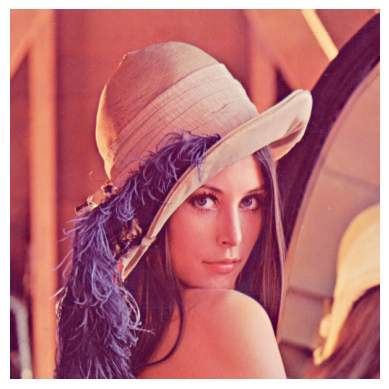

In [90]:
display_ori_image()

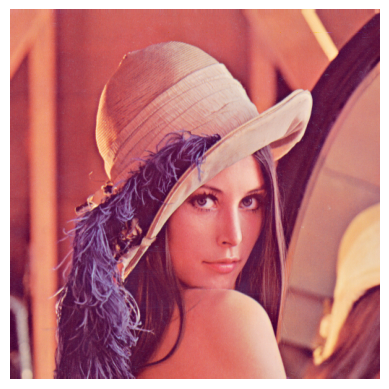

In [88]:
display_image('lsb_only.png')

## Stego Metric

In [37]:
calculate_stego_metrics("lsb_only.png")

Metrics between original (ori-image/lena.png) and stego image (lsb_only.png):
MSE: 0.0009028116861979166
PSNR: 78.57483188820159
SSIM: 0.9999987952461553


(0.0009028116861979166, 78.57483188820159, 0.9999987952461553)

# LSB with ECC

In [38]:
ciphertext

b'\x04\xbc\xec\xd5\xfdS\x1b \x93\xf9^\xe3\xc8k\xac\xa4\x84\x02\xc1\xff?\x84\xc7\xc5m\x1f\xf3\xe6<rRT\t\x8cH\x12\xcc\x87le\x92\x87\xe5\x12w\x8dvp\xa7\xbd\xc1$s*"\xee\x92\xac8\x8c6y.\xff\xc5]\xc7\x80\x98`\x90=\xd1R\x886q\xbb\xaa\xa0f\xd2c\xc2\x80YkI[\x17`NV\xc9P\x16O\xc7\xbe\xb3\x8cY\xcc\x8diy`P\x81\xd3\xdbW\xb4?\xcb7\x01\xa6Iik-\xe3A\x121D%\x04w]k-!\x87CC)\x8ed3\xa4\xe4\xaeB\xee\xb2\x86\xc6\xa7w\xcai\xdc\x05\xdd{\xc2\xce\xef\x1b\xd5]k\x95$~\xbe=\x05\x88$!\xf5\xbf\x03\xa8\xa3\xcd9\xd9\xa7C>\x08\x03\x85;P\x91\xb8\x9e\xdc&d6\xfefG\x0e\xd1n\xbf\x9c\x17\xa3\x90\xab\xb7\xd7\x01\x88\x85\x83\xc63\xcd\xe3\x05\xe1\xa1\xf6\x06mY>\xfe\x9cL\xa2>\xa44\xd7/jm\xa2\x94\x00\'\xa6PE\xbe\x1f\x91\xcd;}=\xa30\x8b5.\xdb+k\x84\xa0\x12\x06V\xb2\x16\x17K?>\xcfS\x1d\x9a'

In [39]:
embed_lsb("lsb_w_ECC.png", ciphertext.hex())

In [100]:
embed_lsb("lsb_test.png", 'l')

In [101]:
extract_lsb("lsb_test.png")

'l'

In [102]:
calculate_stego_metrics("lsb_test.png")

Metrics between original (ori-image/lena.png) and stego image (lsb_test.png):
MSE: 1.7801920572916668e-05
PSNR: 95.62613501860996
SSIM: 0.9999999738635894


(1.7801920572916668e-05, 95.62613501860996, 0.9999999738635894)

In [40]:
extracted_data = extract_lsb("lsb_w_ECC.png")
extracted_data

'04bcecd5fd531b2093f95ee3c86baca48402c1ff3f84c7c56d1ff3e63c725254098c4812cc876c659287e512778d7670a7bdc124732a22ee92ac388c36792effc55dc7809860903dd152883671bbaaa066d263c280596b495b17604e56c950164fc7beb38c59cc8d6979605081d3db57b43fcb3701a649696b2de3411231442504775d6b2d21874343298e6433a4e4ae42eeb286c6a777ca69dc05dd7bc2ceef1bd55d6b95247ebe3d05882421f5bf03a8a3cd39d9a7433e0803853b5091b89edc266436fe66470ed16ebf9c17a390abb7d701888583c633cde305e1a1f6066d593efe9c4ca23ea434d72f6a6da2940027a65045be1f91cd3b7d3da3308b352edb2b6b84a0120656b216174b3f3ecf531d9a'

In [41]:
extracted_data == ciphertext.hex()

True

In [42]:
extracted_data = bytes.fromhex(extracted_data)
extracted_data

b'\x04\xbc\xec\xd5\xfdS\x1b \x93\xf9^\xe3\xc8k\xac\xa4\x84\x02\xc1\xff?\x84\xc7\xc5m\x1f\xf3\xe6<rRT\t\x8cH\x12\xcc\x87le\x92\x87\xe5\x12w\x8dvp\xa7\xbd\xc1$s*"\xee\x92\xac8\x8c6y.\xff\xc5]\xc7\x80\x98`\x90=\xd1R\x886q\xbb\xaa\xa0f\xd2c\xc2\x80YkI[\x17`NV\xc9P\x16O\xc7\xbe\xb3\x8cY\xcc\x8diy`P\x81\xd3\xdbW\xb4?\xcb7\x01\xa6Iik-\xe3A\x121D%\x04w]k-!\x87CC)\x8ed3\xa4\xe4\xaeB\xee\xb2\x86\xc6\xa7w\xcai\xdc\x05\xdd{\xc2\xce\xef\x1b\xd5]k\x95$~\xbe=\x05\x88$!\xf5\xbf\x03\xa8\xa3\xcd9\xd9\xa7C>\x08\x03\x85;P\x91\xb8\x9e\xdc&d6\xfefG\x0e\xd1n\xbf\x9c\x17\xa3\x90\xab\xb7\xd7\x01\x88\x85\x83\xc63\xcd\xe3\x05\xe1\xa1\xf6\x06mY>\xfe\x9cL\xa2>\xa44\xd7/jm\xa2\x94\x00\'\xa6PE\xbe\x1f\x91\xcd;}=\xa30\x8b5.\xdb+k\x84\xa0\x12\x06V\xb2\x16\x17K?>\xcfS\x1d\x9a'

In [43]:
decrypted_message = decrypt(private_key_hex, extracted_data)
print("Decrypted Message:", decrypted_message.decode())

Decrypted Message: 3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup


In [44]:
decrypted_message.decode() == CONTENT

True

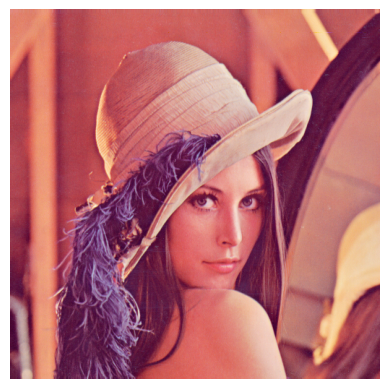

In [92]:
display_image('lsb_w_ECC.png')

## Stego Metric

In [45]:
calculate_stego_metrics("lsb_w_ECC.png")

Metrics between original (ori-image/lena.png) and stego image (lsb_w_ECC.png):
MSE: 0.002788543701171875
PSNR: 73.67702905861711
SSIM: 0.9999929657401828


(0.002788543701171875, 73.67702905861711, 0.9999929657401828)

In [93]:
len(CONTENT)

177

In [95]:
len(ciphertext.hex())

548

# LSB with LZW

In [46]:
compressed_list

[b'\x19',
 b'\x8c',
 b'\xc6',
 b'\x83',
 b'\x81',
 b'\xb0',
 b'\xc4',
 b'`',
 b'4',
 b'\x18',
 b'\x0c',
 b'G',
 b'#',
 b'q',
 b'\x84',
 b'8',
 b'j',
 b'#',
 b'1',
 b'\x9a',
 b'\x0e',
 b'F',
 b'\x93',
 b'\x99',
 b'\xd0',
 b'\xde',
 b'f',
 b'2',
 b'\x9c',
 b'\x85',
 b'F',
 b'H',
 b'\xd1',
 b'\xa4',
 b'\xc2',
 b'n',
 b'\x15',
 b'\x18',
 b'\x8e',
 b'\xa6',
 b'H',
 b'\xf9',
 b'\xba',
 b'.',
 b'#',
 b':',
 b'\x19',
 b'L',
 b'\xe6',
 b'\x13',
 b'`',
 b'\x8e',
 b'\x17',
 b'\x0c',
 b'\x16',
 b'\x8c',
 b'\x06',
 b's',
 b'!',
 b'\xa0',
 b'\x8c',
 b'\xd8',
 b'a',
 b'5',
 b'\x9a',
 b'E',
 b'\xb3',
 b'\x89',
 b'\xd0',
 b'\x8c',
 b'\xc4',
 b'#',
 b'5',
 b'\x1b',
 b'\x05',
 b'\xc2',
 b'\xa3',
 b'\x84',
 b'\xb4',
 b'\xc2',
 b'*',
 b'\x19',
 b'\x0c',
 b'\x85',
 b'F',
 b'\xe3',
 b'}',
 b'\x10',
 b'f',
 b'0',
 b'\x11',
 b'\xc3',
 b'\xea',
 b'C',
 b'\x11',
 b'\xb8',
 b'\x8c',
 b'\xda',
 b'e',
 b'5',
 b'\x18',
 b'N',
 b'f',
 b'S',
 b'h',
 b'\xaa',
 b'T',
 b'n',
 b'\x96',
 b'\x1a',
 b'\x04',
 b'f',
 b'\xb3',

In [47]:
embed_lsb("lsb_w_LZW.png", compressed_list)

In [48]:
extracted_data = extract_lsb("lsb_w_LZW.png")
extracted_data

'\x19\x8cÆ\x83\x81°Ä`4\x18\x0cG#q\x848j#1\x9a\x0eF\x93\x99ÐÞf2\x9c\x85FHÑ¤Ân\x15\x18\x8e¦Hùº.#:\x19Læ\x13`\x8e\x17\x0c\x16\x8c\x06s!\xa0\x8cØa5\x9aE³\x89Ð\x8cÄ#5\x1b\x05Â£\x84´Â*\x19\x0c\x85Fã}\x10f0\x11ÃêC\x11¸\x8cÚe5\x18NfShªTn\x96\x1a\x04f³\x91\x84Úa:Y-&\x83y°Òk\x9f\x99M\x87Zñ¬Âw4\x9b\x84g\x0b\x99\x86´r\x17Ú\r\x15¸©ÜÂ#;\x9b\x8d":åÔë\x1b4\x1aL\x87S\x84\x00'

In [49]:
byte_list = [bytes([ord(char)]) for char in extracted_data]
byte_list

[b'\x19',
 b'\x8c',
 b'\xc6',
 b'\x83',
 b'\x81',
 b'\xb0',
 b'\xc4',
 b'`',
 b'4',
 b'\x18',
 b'\x0c',
 b'G',
 b'#',
 b'q',
 b'\x84',
 b'8',
 b'j',
 b'#',
 b'1',
 b'\x9a',
 b'\x0e',
 b'F',
 b'\x93',
 b'\x99',
 b'\xd0',
 b'\xde',
 b'f',
 b'2',
 b'\x9c',
 b'\x85',
 b'F',
 b'H',
 b'\xd1',
 b'\xa4',
 b'\xc2',
 b'n',
 b'\x15',
 b'\x18',
 b'\x8e',
 b'\xa6',
 b'H',
 b'\xf9',
 b'\xba',
 b'.',
 b'#',
 b':',
 b'\x19',
 b'L',
 b'\xe6',
 b'\x13',
 b'`',
 b'\x8e',
 b'\x17',
 b'\x0c',
 b'\x16',
 b'\x8c',
 b'\x06',
 b's',
 b'!',
 b'\xa0',
 b'\x8c',
 b'\xd8',
 b'a',
 b'5',
 b'\x9a',
 b'E',
 b'\xb3',
 b'\x89',
 b'\xd0',
 b'\x8c',
 b'\xc4',
 b'#',
 b'5',
 b'\x1b',
 b'\x05',
 b'\xc2',
 b'\xa3',
 b'\x84',
 b'\xb4',
 b'\xc2',
 b'*',
 b'\x19',
 b'\x0c',
 b'\x85',
 b'F',
 b'\xe3',
 b'}',
 b'\x10',
 b'f',
 b'0',
 b'\x11',
 b'\xc3',
 b'\xea',
 b'C',
 b'\x11',
 b'\xb8',
 b'\x8c',
 b'\xda',
 b'e',
 b'5',
 b'\x18',
 b'N',
 b'f',
 b'S',
 b'h',
 b'\xaa',
 b'T',
 b'n',
 b'\x96',
 b'\x1a',
 b'\x04',
 b'f',
 b'\xb3',

In [50]:
compressed_list == byte_list

True

In [51]:
# Part 2: Decompression (in-memory)
decompressed_chunks = lzw.decompress(byte_list)

# Join the decompressed chunks into a single byte string
decompressed_bytes = b"".join(decompressed_chunks)

# Convert decompressed bytes back to a string
decompressed_text = decompressed_bytes.decode('utf-8')

print("Decompressed Text (String):", decompressed_text)

Decompressed Text (String): 3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup


In [52]:
decompressed_text == CONTENT

True

## Stego Metric

In [53]:
calculate_stego_metrics("lsb_w_LZW.png")

Metrics between original (ori-image/lena.png) and stego image (lsb_w_LZW.png):
MSE: 0.0008722941080729166
PSNR: 78.72417421832482
SSIM: 0.9999988544716335


(0.0008722941080729166, 78.72417421832482, 0.9999988544716335)

# LSB with ECC, LZW

## ECC

In [54]:
ciphertext.hex()

'04bcecd5fd531b2093f95ee3c86baca48402c1ff3f84c7c56d1ff3e63c725254098c4812cc876c659287e512778d7670a7bdc124732a22ee92ac388c36792effc55dc7809860903dd152883671bbaaa066d263c280596b495b17604e56c950164fc7beb38c59cc8d6979605081d3db57b43fcb3701a649696b2de3411231442504775d6b2d21874343298e6433a4e4ae42eeb286c6a777ca69dc05dd7bc2ceef1bd55d6b95247ebe3d05882421f5bf03a8a3cd39d9a7433e0803853b5091b89edc266436fe66470ed16ebf9c17a390abb7d701888583c633cde305e1a1f6066d593efe9c4ca23ea434d72f6a6da2940027a65045be1f91cd3b7d3da3308b352edb2b6b84a0120656b216174b3f3ecf531d9a'

## LZW

In [55]:
import lzw

# Example text to compress (can be any string)
original_text = ciphertext.hex()

# Convert the original text into bytes (UTF-8 encoding)
original_bytes = original_text.encode('utf-8')

# Part 1: Compression (in-memory)
compressed = lzw.compress(original_bytes)

# Convert compressed generator to a list to see its contents
compressed_list = list(compressed)

# Part 2: Decompression (in-memory)
decompressed_chunks = lzw.decompress(compressed_list)

# Join the decompressed chunks into a single byte string
decompressed_bytes = b"".join(decompressed_chunks)

# Convert decompressed bytes back to a string
decompressed_text = decompressed_bytes.decode('utf-8')

# Print each variable
print("Original Text (String):", original_text)
print("Original Bytes:", original_bytes)
print("Compressed List (Byte Chunks):", compressed_list)
print("Decompressed Bytes:", decompressed_bytes)
print("Decompressed Text (String):", decompressed_text)

# Part 3: Print sizes and results for comparison
original_size = len(original_bytes)
compressed_size = len(b"".join(compressed_list))  # Join to get compressed byte size
decompressed_size = len(decompressed_bytes)

# Print the sizes in bytes
print(f"\nOriginal size: {original_size} bytes")
print(f"Compressed size: {compressed_size} bytes")
print(f"Decompressed size: {decompressed_size} bytes")

# Check if decompression was successful
if decompressed_text == original_text:
    print("Decompression was successful!")
else:
    print("Decompression failed.")

Original Text (String): 04bcecd5fd531b2093f95ee3c86baca48402c1ff3f84c7c56d1ff3e63c725254098c4812cc876c659287e512778d7670a7bdc124732a22ee92ac388c36792effc55dc7809860903dd152883671bbaaa066d263c280596b495b17604e56c950164fc7beb38c59cc8d6979605081d3db57b43fcb3701a649696b2de3411231442504775d6b2d21874343298e6433a4e4ae42eeb286c6a777ca69dc05dd7bc2ceef1bd55d6b95247ebe3d05882421f5bf03a8a3cd39d9a7433e0803853b5091b89edc266436fe66470ed16ebf9c17a390abb7d701888583c633cde305e1a1f6066d593efe9c4ca23ea434d72f6a6da2940027a65045be1f91cd3b7d3da3308b352edb2b6b84a0120656b216174b3f3ecf531d9a
Original Bytes: b'04bcecd5fd531b2093f95ee3c86baca48402c1ff3f84c7c56d1ff3e63c725254098c4812cc876c659287e512778d7670a7bdc124732a22ee92ac388c36792effc55dc7809860903dd152883671bbaaa066d263c280596b495b17604e56c950164fc7beb38c59cc8d6979605081d3db57b43fcb3701a649696b2de3411231442504775d6b2d21874343298e6433a4e4ae42eeb286c6a777ca69dc05dd7bc2ceef1bd55d6b95247ebe3d05882421f5bf03a8a3cd39d9a7433e0803853b5091b89edc266436fe66470ed16ebf9c1

## LSB

In [56]:
compressed_list

[b'\x18',
 b'\r',
 b'\x0c',
 b'F',
 b'3',
 b')',
 b'\x8c',
 b'\xc8',
 b'5',
 b'3',
 b'B',
 b'\x06',
 b'c',
 b'\x13',
 b'\x10',
 b'\xc8',
 b'`',
 b'9',
 b'\x19',
 b'\x99',
 b'\x87',
 b'#',
 b'S',
 b')',
 b'\x94',
 b'f',
 b'c',
 b'\x1c',
 b'\r',
 b'\x8c',
 b'F',
 b'\x13',
 b'\x19',
 b'\x84',
 b'h',
 b'8',
 b'\x1a',
 b'\x0c',
 b'\x06',
 b'F',
 b'1',
 b'\x89',
 b'\x98',
 b'\xcd',
 b'\x12',
 b'\x90',
 b'\x98',
 b'\xc6',
 b'\xe6',
 b'1',
 b'\xa8',
 b'\xd8',
 b'\xc9',
 b'&',
 b'\x94',
 b'\x19',
 b'F',
 b'\xd1',
 b'\x81',
 b'\xb8',
 b'\xc8',
 b'k',
 b'7',
 b'\x91',
 b'\x0e',
 b'G',
 b'\x06',
 b'9',
 b'\x00',
 b'\xc6',
 b'I',
 b'\x19',
 b'\x1b',
 b'\x8d',
 b'\x8c',
 b'c',
 b'a',
 b'\xa8',
 b'\xe4',
 b'd',
 b'8',
 b'\x1b',
 b'\x99',
 b'F',
 b'\xb3',
 b'\xf1',
 b'\xb8',
 b'\xdc',
 b'p',
 b'd',
 b'\xa1',
 b'\r',
 b'\xc6',
 b'\x06',
 b'\x11',
 b'\xb9',
 b'\x88',
 b'\xc9',
 b'%',
 b'\x19',
 b'\r',
 b'\x06',
 b'\xe3',
 b'1',
 b'\x91',
 b'\x84',
 b'd',
 b'2',
 b'\x8b',
 b'Q',
 b'\xe3',
 b'\xa3',
 b'1'

In [57]:
embed_lsb("lsb_w_ECC_LZW.png", compressed_list)

In [58]:
extracted_data = extract_lsb("lsb_w_ECC_LZW.png")
extracted_data

'\x18\r\x0cF3)\x8cÈ53B\x06c\x13\x10È`9\x19\x99\x87#S)\x94fc\x1c\r\x8cF\x13\x19\x84h8\x1a\x0c\x06F1\x89\x98Í\x12\x90\x98Ææ1¨ØÉ&\x94\x19FÑ\x81¸Èk7\x91\x0eG\x069\x00ÆI\x19\x1b\x8d\x8cca¨äd8\x1b\x99F³ñ¸Üpd¡\rÆ\x06\x11¹\x88É%\x19\r\x06ã1\x91\x84d2\x8bQã£1Äðf6\x1bÑÌ²yhÖ±O\x88F¢\x03\x01\x99\x92a8³Z\x06ðØá\x84Â0\x1bKÆSC\x1d aF\x8d\x8d"\x86!\x8d\n\x05K¡Å\x06\x03\x11°ÐÍ+1\x19LVYhäÇ\x192\r\x876¡¶ `8\x18\x99.Æ!\xadXi\x121ç*c\x13\x0eXs£\x8d\x8c\x8c\x91q\xa0Æ\x7f\x0c\x1a\r&ð*u¿td\x19\x0ci;\r\x80Êw3Ø\x0cãæQ¡\x87«aÍÒ(cj\xad:=£¬b.õl4\x16Ù\r\x84qÌQJÕ+5vÄY«\\£0ÔÄfº\x98G\x06\x18Æ¬9\x19\x03\x95UÒ\x19Z\x85Ô8\rC6µ\x10CC\x80äeV\x18FYh\x19\x936YS\x84\x19Vm\x13ICwô9U\x06!\x887TYE\x9a\x08\x0e\x11\x84ÑþEØ\x81\x95µI\x9af\t\x08DVÁ\x95\x9f\r\x11àÈ3\x19QðÌ4TC!\x99ÝKÕðå"Háå\x15\x02}âôL1Aà¨\x91v\x7fC6¡\x9cN!\x048bFÒ\x16\x01?`Rä9\x95c\x904J<\x18ßd2\x01\x18P\x00'

In [59]:
byte_list = [bytes([ord(char)]) for char in extracted_data]
byte_list

[b'\x18',
 b'\r',
 b'\x0c',
 b'F',
 b'3',
 b')',
 b'\x8c',
 b'\xc8',
 b'5',
 b'3',
 b'B',
 b'\x06',
 b'c',
 b'\x13',
 b'\x10',
 b'\xc8',
 b'`',
 b'9',
 b'\x19',
 b'\x99',
 b'\x87',
 b'#',
 b'S',
 b')',
 b'\x94',
 b'f',
 b'c',
 b'\x1c',
 b'\r',
 b'\x8c',
 b'F',
 b'\x13',
 b'\x19',
 b'\x84',
 b'h',
 b'8',
 b'\x1a',
 b'\x0c',
 b'\x06',
 b'F',
 b'1',
 b'\x89',
 b'\x98',
 b'\xcd',
 b'\x12',
 b'\x90',
 b'\x98',
 b'\xc6',
 b'\xe6',
 b'1',
 b'\xa8',
 b'\xd8',
 b'\xc9',
 b'&',
 b'\x94',
 b'\x19',
 b'F',
 b'\xd1',
 b'\x81',
 b'\xb8',
 b'\xc8',
 b'k',
 b'7',
 b'\x91',
 b'\x0e',
 b'G',
 b'\x06',
 b'9',
 b'\x00',
 b'\xc6',
 b'I',
 b'\x19',
 b'\x1b',
 b'\x8d',
 b'\x8c',
 b'c',
 b'a',
 b'\xa8',
 b'\xe4',
 b'd',
 b'8',
 b'\x1b',
 b'\x99',
 b'F',
 b'\xb3',
 b'\xf1',
 b'\xb8',
 b'\xdc',
 b'p',
 b'd',
 b'\xa1',
 b'\r',
 b'\xc6',
 b'\x06',
 b'\x11',
 b'\xb9',
 b'\x88',
 b'\xc9',
 b'%',
 b'\x19',
 b'\r',
 b'\x06',
 b'\xe3',
 b'1',
 b'\x91',
 b'\x84',
 b'd',
 b'2',
 b'\x8b',
 b'Q',
 b'\xe3',
 b'\xa3',
 b'1'

In [60]:
compressed_list == byte_list

True

In [61]:
# Part 2: Decompression (in-memory)
decompressed_chunks = lzw.decompress(byte_list)

# Join the decompressed chunks into a single byte string
decompressed_bytes = b"".join(decompressed_chunks)

# Convert decompressed bytes back to a string
decompressed_text = decompressed_bytes.decode('utf-8')

print("Decompressed Text (String):", decompressed_text)

Decompressed Text (String): 04bcecd5fd531b2093f95ee3c86baca48402c1ff3f84c7c56d1ff3e63c725254098c4812cc876c659287e512778d7670a7bdc124732a22ee92ac388c36792effc55dc7809860903dd152883671bbaaa066d263c280596b495b17604e56c950164fc7beb38c59cc8d6979605081d3db57b43fcb3701a649696b2de3411231442504775d6b2d21874343298e6433a4e4ae42eeb286c6a777ca69dc05dd7bc2ceef1bd55d6b95247ebe3d05882421f5bf03a8a3cd39d9a7433e0803853b5091b89edc266436fe66470ed16ebf9c17a390abb7d701888583c633cde305e1a1f6066d593efe9c4ca23ea434d72f6a6da2940027a65045be1f91cd3b7d3da3308b352edb2b6b84a0120656b216174b3f3ecf531d9a


In [62]:
decompressed_text == ciphertext.hex()

True

In [63]:
cipher_data = bytes.fromhex(decompressed_text)
cipher_data

b'\x04\xbc\xec\xd5\xfdS\x1b \x93\xf9^\xe3\xc8k\xac\xa4\x84\x02\xc1\xff?\x84\xc7\xc5m\x1f\xf3\xe6<rRT\t\x8cH\x12\xcc\x87le\x92\x87\xe5\x12w\x8dvp\xa7\xbd\xc1$s*"\xee\x92\xac8\x8c6y.\xff\xc5]\xc7\x80\x98`\x90=\xd1R\x886q\xbb\xaa\xa0f\xd2c\xc2\x80YkI[\x17`NV\xc9P\x16O\xc7\xbe\xb3\x8cY\xcc\x8diy`P\x81\xd3\xdbW\xb4?\xcb7\x01\xa6Iik-\xe3A\x121D%\x04w]k-!\x87CC)\x8ed3\xa4\xe4\xaeB\xee\xb2\x86\xc6\xa7w\xcai\xdc\x05\xdd{\xc2\xce\xef\x1b\xd5]k\x95$~\xbe=\x05\x88$!\xf5\xbf\x03\xa8\xa3\xcd9\xd9\xa7C>\x08\x03\x85;P\x91\xb8\x9e\xdc&d6\xfefG\x0e\xd1n\xbf\x9c\x17\xa3\x90\xab\xb7\xd7\x01\x88\x85\x83\xc63\xcd\xe3\x05\xe1\xa1\xf6\x06mY>\xfe\x9cL\xa2>\xa44\xd7/jm\xa2\x94\x00\'\xa6PE\xbe\x1f\x91\xcd;}=\xa30\x8b5.\xdb+k\x84\xa0\x12\x06V\xb2\x16\x17K?>\xcfS\x1d\x9a'

In [64]:
decrypted_message = decrypt(private_key_hex, cipher_data)
print("Decrypted Message:", decrypted_message.decode())

Decrypted Message: 3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup


In [65]:
decrypted_message.decode() == CONTENT

True

## Stego Metric

In [66]:
calculate_stego_metrics("lsb_w_ECC_LZW.png")

Metrics between original (ori-image/lena.png) and stego image (lsb_w_ECC_LZW.png):
MSE: 0.002208709716796875
PSNR: 74.68941719092136
SSIM: 0.999995191957198


(0.002208709716796875, 74.68941719092136, 0.999995191957198)

# LSB with Huffman

In [67]:
compressed_data

bytearray(b'\x02\xdfy>\xa8\x7f\x12G\xf7S\x11\x1e\xfb\xedYu\xcf\xc6)\x91\xd52\xe6\xc3\xa3usi\xf9\xd3OD;\xfb\xae\xa6\xf8\xde\xf8\x93\x80\xe1\xef\x03\x87\xed9\x90\xa2;\x10#\xf3\xe0\xdb\xca#\xbctG\xbe\x8f\xe9\xea\xa3%iQ\x9a[\xd1Wc&\xa6}\x835x\x0f\x8e\xd1\x01\xb5\x1c\x19^\xdd\xb2\x01d\xe5\x85J\x8a\xddr\x9e\x96\xcf\xcbF\xd5\xb9\x15>\xad\xd8')

In [68]:
compressed_data.hex()

'02df793ea87f1247f753111efbed5975cfc62991d532e6c3a3757369f9d34f443bfbaea6f8def89380e1ef0387ed3990a23b1023f3e0dbca23bc7447be8fe9eaa32569519a5bd1576326a67d8335780f8ed101b51c195eddb20164e5854a8add729e96cfcb46d5b9153eadd8'

In [69]:
embed_lsb("lsb_w_Huffman.png", compressed_data.hex())

In [70]:
extracted_data = extract_lsb("lsb_w_Huffman.png")
extracted_data

'02df793ea87f1247f753111efbed5975cfc62991d532e6c3a3757369f9d34f443bfbaea6f8def89380e1ef0387ed3990a23b1023f3e0dbca23bc7447be8fe9eaa32569519a5bd1576326a67d8335780f8ed101b51c195eddb20164e5854a8add729e96cfcb46d5b9153eadd8'

In [105]:
len(extract_lsb("lsb_w_Huffman.png"))

216

In [106]:
len(CONTENT)

177

In [71]:
huffman_data = bytearray.fromhex(extracted_data)
huffman_data

bytearray(b'\x02\xdfy>\xa8\x7f\x12G\xf7S\x11\x1e\xfb\xedYu\xcf\xc6)\x91\xd52\xe6\xc3\xa3usi\xf9\xd3OD;\xfb\xae\xa6\xf8\xde\xf8\x93\x80\xe1\xef\x03\x87\xed9\x90\xa2;\x10#\xf3\xe0\xdb\xca#\xbctG\xbe\x8f\xe9\xea\xa3%iQ\x9a[\xd1Wc&\xa6}\x835x\x0f\x8e\xd1\x01\xb5\x1c\x19^\xdd\xb2\x01d\xe5\x85J\x8a\xddr\x9e\x96\xcf\xcbF\xd5\xb9\x15>\xad\xd8')

In [72]:
decompressed_data = huffman_decompress(huffman_data, huffman_tree)
print("Decompressed Data (as bytes):", decompressed_data)
print("Decompressed Data (as string):", decompressed_data.decode())

Decompressed Data (as bytes): bytearray(b'3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup')
Decompressed Data (as string): 3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup


In [73]:
decompressed_data.decode() == CONTENT

True

## Stego Metric

In [74]:
calculate_stego_metrics("lsb_w_Huffman.png")

Metrics between original (ori-image/lena.png) and stego image (lsb_w_Huffman.png):
MSE: 0.00107574462890625
PSNR: 77.81371174500211
SSIM: 0.9999984186394683


(0.00107574462890625, 77.81371174500211, 0.9999984186394683)

# LSB with ECC, Huffman

## ECC

In [75]:
ciphertext.hex()

'04bcecd5fd531b2093f95ee3c86baca48402c1ff3f84c7c56d1ff3e63c725254098c4812cc876c659287e512778d7670a7bdc124732a22ee92ac388c36792effc55dc7809860903dd152883671bbaaa066d263c280596b495b17604e56c950164fc7beb38c59cc8d6979605081d3db57b43fcb3701a649696b2de3411231442504775d6b2d21874343298e6433a4e4ae42eeb286c6a777ca69dc05dd7bc2ceef1bd55d6b95247ebe3d05882421f5bf03a8a3cd39d9a7433e0803853b5091b89edc266436fe66470ed16ebf9c17a390abb7d701888583c633cde305e1a1f6066d593efe9c4ca23ea434d72f6a6da2940027a65045be1f91cd3b7d3da3308b352edb2b6b84a0120656b216174b3f3ecf531d9a'

## Huffman

In [76]:
# Example Usage of Huffman Compression/Decompression

# Step 1: The original plaintext data (as a byte string)
plaintext = ciphertext.hex().encode()

# Print the original data
print("Original Data (as bytes):", plaintext)
print("Original Data (as string):", plaintext.decode())

# Step 2: Compress the plaintext data using Huffman encoding
compressed_data, huffman_tree = huffman_compress(plaintext)
print("Compressed Data (in bytes):", compressed_data)

Original Data (as bytes): b'04bcecd5fd531b2093f95ee3c86baca48402c1ff3f84c7c56d1ff3e63c725254098c4812cc876c659287e512778d7670a7bdc124732a22ee92ac388c36792effc55dc7809860903dd152883671bbaaa066d263c280596b495b17604e56c950164fc7beb38c59cc8d6979605081d3db57b43fcb3701a649696b2de3411231442504775d6b2d21874343298e6433a4e4ae42eeb286c6a777ca69dc05dd7bc2ceef1bd55d6b95247ebe3d05882421f5bf03a8a3cd39d9a7433e0803853b5091b89edc266436fe66470ed16ebf9c17a390abb7d701888583c633cde305e1a1f6066d593efe9c4ca23ea434d72f6a6da2940027a65045be1f91cd3b7d3da3308b352edb2b6b84a0120656b216174b3f3ecf531d9a'
Original Data (as string): 04bcecd5fd531b2093f95ee3c86baca48402c1ff3f84c7c56d1ff3e63c725254098c4812cc876c659287e512778d7670a7bdc124732a22ee92ac388c36792effc55dc7809860903dd152883671bbaaa066d263c280596b495b17604e56c950164fc7beb38c59cc8d6979605081d3db57b43fcb3701a649696b2de3411231442504775d6b2d21874343298e6433a4e4ae42eeb286c6a777ca69dc05dd7bc2ceef1bd55d6b95247ebe3d05882421f5bf03a8a3cd39d9a7433e0803853b5091b89edc266436fe6

## LSB

In [77]:
compressed_data

bytearray(b'\x08h}]\x9b\t\xbf7\xc6/\x02\xb5_\xd4\xe7\x1d\x18Hl\xd3\x00\xf0H\xda\xdb\xe90\x0f^\xfd\xac\xbc\xb8bM\x84<\xddJ\xed\xeb,J[<\xaaI\xae\xa6\x1ay\xd3\xc8\xaf\xc1\xccU,\x1d\xf4M\xfe\xa2\xc5\x00\xdb\xb9\xdaF$\xe6&\xf9\x93\xbcD\xfe\xa3w\x11\x16\xee\x9c\xef\xdcF\xb2\xe7\x82\xb7:\xe6\x85\xbe\xd2\xb6>\x80\xdau\x7fM\xb2\xddI\xe2\xa2\xe6\xb6C\x9f\x97\xbax\xf0\xd7\xfac\x1e\x82\xe2\xe7\xc9_\x83<\xf3\x88\xcbh\xaa\xb9\xe7\xc9\xc3J\x8f\x8f\xc2E\xe8\xff\x18X\x15\x8cU|N\xde\x1a\xaa\xd1\xe2\x9dk\x99\xa7\xdc\xd5P7\x9b\xb9\xe7+\xc8\xa5u\xf9kD\xc8\xc3\x0bpo\x14\x1f\xd9\xf2\x92\x1a\x8f\xf5doK\xf7\xb6#t%\x9d\xce\xe8\xfe\x05\xee\x8ae\x93\xe5p-:\x1f&\x17z\x9acDKO\xde\xff\xd9_kS\x13\x0en\xe9\xb2\xf5\x05-\x8d\x1c\xf5\x18\xf8\x9a\xc0\xe1\xe9\x1c(f\xca\x1e\xb6\x8bu0#\xd9\xf7\xa9\xf9\x1f\xf6G\xfb\xc5\x97\xc7\xe7H\x16<n\xbe|>:\x87\xf0\xf5\xd0\xbf9!\x00')

In [78]:
compressed_data.hex()

'08687d5d9b09bf37c62f02b55fd4e71d18486cd300f048dadbe9300f5efdacbcb8624d843cdd4aedeb2c4a5b3caa49aea61a79d3c8afc1cc552c1df44dfea2c500dbb9da4624e626f993bc44fea3771116ee9cefdc46b2e782b73ae685bed2b63e80da757f4db2dd49e2a2e6b6439f97ba78f0d7fa631e82e2e7c95f833cf388cb68aab9e7c9c34a8f8fc245e8ff1858158c557c4ede1aaad1e29d6b99a7dcd550379bb9e72bc8a575f96b44c8c30b706f141fd9f2921a8ff5646f4bf7b62374259dcee8fe05ee8a6593e5702d3a1f26177a9a63444b4fdeffd95f6b53130e6ee9b2f5052d8d1cf518f89ac0e1e91c2866ca1eb68b753023d9f7a9f91ff647fbc597c7e748163c6ebe7c3e3a87f0f5d0bf392100'

In [107]:
len(compressed_data.hex())

552

In [109]:
len(ciphertext.hex())

548

In [79]:
embed_lsb('LSB_w_ECC_Huffman.png', compressed_data.hex())

In [80]:
extracted_data = extract_lsb('LSB_w_ECC_Huffman.png')
extracted_data

'08687d5d9b09bf37c62f02b55fd4e71d18486cd300f048dadbe9300f5efdacbcb8624d843cdd4aedeb2c4a5b3caa49aea61a79d3c8afc1cc552c1df44dfea2c500dbb9da4624e626f993bc44fea3771116ee9cefdc46b2e782b73ae685bed2b63e80da757f4db2dd49e2a2e6b6439f97ba78f0d7fa631e82e2e7c95f833cf388cb68aab9e7c9c34a8f8fc245e8ff1858158c557c4ede1aaad1e29d6b99a7dcd550379bb9e72bc8a575f96b44c8c30b706f141fd9f2921a8ff5646f4bf7b62374259dcee8fe05ee8a6593e5702d3a1f26177a9a63444b4fdeffd95f6b53130e6ee9b2f5052d8d1cf518f89ac0e1e91c2866ca1eb68b753023d9f7a9f91ff647fbc597c7e748163c6ebe7c3e3a87f0f5d0bf392100'

In [81]:
huffman_data = bytearray.fromhex(extracted_data)
huffman_data

bytearray(b'\x08h}]\x9b\t\xbf7\xc6/\x02\xb5_\xd4\xe7\x1d\x18Hl\xd3\x00\xf0H\xda\xdb\xe90\x0f^\xfd\xac\xbc\xb8bM\x84<\xddJ\xed\xeb,J[<\xaaI\xae\xa6\x1ay\xd3\xc8\xaf\xc1\xccU,\x1d\xf4M\xfe\xa2\xc5\x00\xdb\xb9\xdaF$\xe6&\xf9\x93\xbcD\xfe\xa3w\x11\x16\xee\x9c\xef\xdcF\xb2\xe7\x82\xb7:\xe6\x85\xbe\xd2\xb6>\x80\xdau\x7fM\xb2\xddI\xe2\xa2\xe6\xb6C\x9f\x97\xbax\xf0\xd7\xfac\x1e\x82\xe2\xe7\xc9_\x83<\xf3\x88\xcbh\xaa\xb9\xe7\xc9\xc3J\x8f\x8f\xc2E\xe8\xff\x18X\x15\x8cU|N\xde\x1a\xaa\xd1\xe2\x9dk\x99\xa7\xdc\xd5P7\x9b\xb9\xe7+\xc8\xa5u\xf9kD\xc8\xc3\x0bpo\x14\x1f\xd9\xf2\x92\x1a\x8f\xf5doK\xf7\xb6#t%\x9d\xce\xe8\xfe\x05\xee\x8ae\x93\xe5p-:\x1f&\x17z\x9acDKO\xde\xff\xd9_kS\x13\x0en\xe9\xb2\xf5\x05-\x8d\x1c\xf5\x18\xf8\x9a\xc0\xe1\xe9\x1c(f\xca\x1e\xb6\x8bu0#\xd9\xf7\xa9\xf9\x1f\xf6G\xfb\xc5\x97\xc7\xe7H\x16<n\xbe|>:\x87\xf0\xf5\xd0\xbf9!\x00')

In [82]:
decompressed_data = huffman_decompress(huffman_data, huffman_tree)
print("Decompressed Data (as bytes):", decompressed_data)
print("Decompressed Data (as string):", decompressed_data.decode())

Decompressed Data (as bytes): bytearray(b'04bcecd5fd531b2093f95ee3c86baca48402c1ff3f84c7c56d1ff3e63c725254098c4812cc876c659287e512778d7670a7bdc124732a22ee92ac388c36792effc55dc7809860903dd152883671bbaaa066d263c280596b495b17604e56c950164fc7beb38c59cc8d6979605081d3db57b43fcb3701a649696b2de3411231442504775d6b2d21874343298e6433a4e4ae42eeb286c6a777ca69dc05dd7bc2ceef1bd55d6b95247ebe3d05882421f5bf03a8a3cd39d9a7433e0803853b5091b89edc266436fe66470ed16ebf9c17a390abb7d701888583c633cde305e1a1f6066d593efe9c4ca23ea434d72f6a6da2940027a65045be1f91cd3b7d3da3308b352edb2b6b84a0120656b216174b3f3ecf531d9a')
Decompressed Data (as string): 04bcecd5fd531b2093f95ee3c86baca48402c1ff3f84c7c56d1ff3e63c725254098c4812cc876c659287e512778d7670a7bdc124732a22ee92ac388c36792effc55dc7809860903dd152883671bbaaa066d263c280596b495b17604e56c950164fc7beb38c59cc8d6979605081d3db57b43fcb3701a649696b2de3411231442504775d6b2d21874343298e6433a4e4ae42eeb286c6a777ca69dc05dd7bc2ceef1bd55d6b95247ebe3d05882421f5bf03a8a3cd39d9a7433e0803853b

In [83]:
cipher_data = bytes.fromhex(decompressed_data.decode())
cipher_data

b'\x04\xbc\xec\xd5\xfdS\x1b \x93\xf9^\xe3\xc8k\xac\xa4\x84\x02\xc1\xff?\x84\xc7\xc5m\x1f\xf3\xe6<rRT\t\x8cH\x12\xcc\x87le\x92\x87\xe5\x12w\x8dvp\xa7\xbd\xc1$s*"\xee\x92\xac8\x8c6y.\xff\xc5]\xc7\x80\x98`\x90=\xd1R\x886q\xbb\xaa\xa0f\xd2c\xc2\x80YkI[\x17`NV\xc9P\x16O\xc7\xbe\xb3\x8cY\xcc\x8diy`P\x81\xd3\xdbW\xb4?\xcb7\x01\xa6Iik-\xe3A\x121D%\x04w]k-!\x87CC)\x8ed3\xa4\xe4\xaeB\xee\xb2\x86\xc6\xa7w\xcai\xdc\x05\xdd{\xc2\xce\xef\x1b\xd5]k\x95$~\xbe=\x05\x88$!\xf5\xbf\x03\xa8\xa3\xcd9\xd9\xa7C>\x08\x03\x85;P\x91\xb8\x9e\xdc&d6\xfefG\x0e\xd1n\xbf\x9c\x17\xa3\x90\xab\xb7\xd7\x01\x88\x85\x83\xc63\xcd\xe3\x05\xe1\xa1\xf6\x06mY>\xfe\x9cL\xa2>\xa44\xd7/jm\xa2\x94\x00\'\xa6PE\xbe\x1f\x91\xcd;}=\xa30\x8b5.\xdb+k\x84\xa0\x12\x06V\xb2\x16\x17K?>\xcfS\x1d\x9a'

In [84]:
decrypted_message = decrypt(private_key_hex, cipher_data)
print("Decrypted Message:", decrypted_message.decode())

Decrypted Message: 3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup


In [85]:
decrypted_message.decode() == CONTENT

True

## Stego Metric

In [86]:
calculate_stego_metrics('LSB_w_ECC_Huffman.png')

Metrics between original (ori-image/lena.png) and stego image (LSB_w_ECC_Huffman.png):
MSE: 0.0027554829915364585
PSNR: 73.72882626219416
SSIM: 0.9999929901881417


(0.0027554829915364585, 73.72882626219416, 0.9999929901881417)

# Test

In [143]:
ciphertexts

'W1tbNDcyLCAzMzZdLCBbMzAyLCA0NjBdXSwgW1s0NzIsIDMzNl0sIFszMDIsIDQ2MF1dLCBbWzQ3MiwgMzM2XSwgWzE1NCwgMTc2XV0sIFtbNDcyLCAzMzZdLCBbMzQxLCAzODldXSwgW1s0NzIsIDMzNl0sIFsxNTcsIDU1XV0sIFtbNDcyLCAzMzZdLCBbNTk5LCAzNzFdXSwgW1s0NzIsIDMzNl0sIFs1MTMsIDYxMF1dLCBbWzQ3MiwgMzM2XSwgWzE1NCwgMTc2XV0sIFtbNDcyLCAzMzZdLCBbNTEzLCA2MTBdXSwgW1s0NzIsIDMzNl0sIFs1OTksIDM3MV1dLCBbWzQ3MiwgMzM2XSwgWzYzMiwgNjcxXV0sIFtbNDcyLCAzMzZdLCBbMjY4LCAyMjldXSwgW1s0NzIsIDMzNl0sIFs1MTMsIDYxMF1dLCBbWzQ3MiwgMzM2XSwgWzUxMywgNjEwXV0sIFtbNDcyLCAzMzZdLCBbNTEzLCA2MTBdXSwgW1s0NzIsIDMzNl0sIFs2OTYsIDkwXV0sIFtbNDcyLCAzMzZdLCBbMjgwLCA1MDRdXSwgW1s0NzIsIDMzNl0sIFs3MzEsIDIyMl1dLCBbWzQ3MiwgMzM2XSwgWzI2NCwgNDE0XV0sIFtbNDcyLCAzMzZdLCBbNDcwLCAzMTBdXSwgW1s0NzIsIDMzNl0sIFs2NjYsIDg1XV0sIFtbNDcyLCAzMzZdLCBbMzI5LCAzODJdXSwgW1s0NzIsIDMzNl0sIFsxMjgsIDI1Ml1dLCBbWzQ3MiwgMzM2XSwgWzU3MCwgMjQwXV0sIFtbNDcyLCAzMzZdLCBbNTkxLCAxMDRdXSwgW1s0NzIsIDMzNl0sIFs1MTMsIDE0MV1dLCBbWzQ3MiwgMzM2XSwgWzQ3MCwgMzEwXV0sIFtbNDcyLCAzMzZdLCBbMjc0LCAzMjldXSwgW1s0NzIsIDMzNl0sIFs1MTAsIDMyMl1

In [144]:
embed_lsb("lsb_tests.png", ciphertexts)

In [145]:
512 * 512 * 3

786432

In [146]:
extract_lsb("lsb_tests.png")

'W1tbNDcyLCAzMzZdLCBbMzAyLCA0NjBdXSwgW1s0NzIsIDMzNl0sIFszMDIsIDQ2MF1dLCBbWzQ3MiwgMzM2XSwgWzE1NCwgMTc2XV0sIFtbNDcyLCAzMzZdLCBbMzQxLCAzODldXSwgW1s0NzIsIDMzNl0sIFsxNTcsIDU1XV0sIFtbNDcyLCAzMzZdLCBbNTk5LCAzNzFdXSwgW1s0NzIsIDMzNl0sIFs1MTMsIDYxMF1dLCBbWzQ3MiwgMzM2XSwgWzE1NCwgMTc2XV0sIFtbNDcyLCAzMzZdLCBbNTEzLCA2MTBdXSwgW1s0NzIsIDMzNl0sIFs1OTksIDM3MV1dLCBbWzQ3MiwgMzM2XSwgWzYzMiwgNjcxXV0sIFtbNDcyLCAzMzZdLCBbMjY4LCAyMjldXSwgW1s0NzIsIDMzNl0sIFs1MTMsIDYxMF1dLCBbWzQ3MiwgMzM2XSwgWzUxMywgNjEwXV0sIFtbNDcyLCAzMzZdLCBbNTEzLCA2MTBdXSwgW1s0NzIsIDMzNl0sIFs2OTYsIDkwXV0sIFtbNDcyLCAzMzZdLCBbMjgwLCA1MDRdXSwgW1s0NzIsIDMzNl0sIFs3MzEsIDIyMl1dLCBbWzQ3MiwgMzM2XSwgWzI2NCwgNDE0XV0sIFtbNDcyLCAzMzZdLCBbNDcwLCAzMTBdXSwgW1s0NzIsIDMzNl0sIFs2NjYsIDg1XV0sIFtbNDcyLCAzMzZdLCBbMzI5LCAzODJdXSwgW1s0NzIsIDMzNl0sIFsxMjgsIDI1Ml1dLCBbWzQ3MiwgMzM2XSwgWzU3MCwgMjQwXV0sIFtbNDcyLCAzMzZdLCBbNTkxLCAxMDRdXSwgW1s0NzIsIDMzNl0sIFs1MTMsIDE0MV1dLCBbWzQ3MiwgMzM2XSwgWzQ3MCwgMzEwXV0sIFtbNDcyLCAzMzZdLCBbMjc0LCAzMjldXSwgW1s0NzIsIDMzNl0sIFs1MTAsIDMyMl1

In [147]:
extract_lsb("lsb_tests.png") == ciphertexts

True

In [148]:
calculate_stego_metrics("lsb_tests.png")

Metrics between original (ori-image/lena.png) and stego image (lsb_tests.png):
MSE: 0.030877431233723957
PSNR: 63.23439197682917
SSIM: 0.9997543791141043


(0.030877431233723957, 63.23439197682917, 0.9997543791141043)